# Fair Causal Reasoning with Detoxify and Quantum Computing (Bias Detection)

# Install Necessary Libraries

In [10]:
!pip install dowhy detoxify qiskit
!pip install qiskit-aer

# Step 1: Setup and Imports

In [13]:
# Install required libraries (run in terminal or Kaggle/Jupyter first)
!pip install dowhy qiskit qiskit-aer transformers detoxify

Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt" to /root/.cache/torch/hub/checkpoints/toxic_original-c1212f89.ckpt
100%|██████████| 418M/418M [00:01<00:00, 322MB/s] 


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Libraries and models loaded successfully!


# Imports Necessary Libraries

In [23]:
import pandas as pd
import numpy as np
from dowhy import CausalModel
from detoxify import Detoxify
from transformers import pipeline
import xgboost as xgb
from sklearn.model_selection import train_test_split
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Initialize models
bias_detector = Detoxify('original')
sentiment_analyzer = pipeline("sentiment-analysis", model="roberta-base")

print("Libraries and models loaded successfully!")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Libraries and models loaded successfully!


# Step 2: Load and Prepare the Dataset

In [24]:
# Load dataset (adjust path)
df = pd.read_csv("/kaggle/input/twitter-tweets-sentiment-dataset/Tweets.csv")

# Subset for processing
df = df.sample(n=10000, random_state=42)

# Simulate race with realistic distribution
np.random.seed(42)
races = ["African American", "Caucasian", "Asian", "Hispanic"]
df["race"] = np.random.choice(races, size=len(df), p=[0.25, 0.25, 0.25, 0.25])

# Clean text
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
        text = re.sub(r"@\w+|\#", "", text)
        return text.strip()
    return ""

df["clean_text"] = df["text"].apply(clean_text)

# Map sentiment to binary
df["sentiment"] = df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)

# Add bias score using Detoxify
df["bias_score"] = df["clean_text"].apply(
    lambda x: bias_detector.predict(x)["identity_attack"] if x else 0.0
)

# Dynamically set bias threshold to balance treatment/control (e.g., median or quantile)
bias_threshold = df["bias_score"].quantile(0.75)  # Top 25% as biased
df["bias_present"] = df["bias_score"].apply(lambda x: 1 if x > bias_threshold else 0)

# Check distribution
print("Bias Present Distribution:")
print(df["bias_present"].value_counts())
print("Sentiment Distribution:")
print(df["sentiment"].value_counts())

# Display sample
df[["clean_text", "race", "bias_score", "bias_present", "sentiment"]].head()

Bias Present Distribution:
bias_present
0    7500
1    2500
Name: count, dtype: int64
Sentiment Distribution:
sentiment
0    6916
1    3084
Name: count, dtype: int64


,clean_text,race,bias_score,bias_present,sentiment
1588,WOOOOOOOOOO are you coming to Nottingham at ...,Caucasian,0.000164,0,1
23879,resting had a whole day of walking,Hispanic,0.000164,0,0
6561,"was in Palawan a couple of days ago, i`ll try ...",Asian,0.000134,0,0
2602,I know! I`m so slow its horrible. DON`T TELL O...,Asian,0.000343,1,0
4003,"Glad I went out, glad I didn`t leave early, an...",African American,0.000151,0,1


# Step 3: Define Causal Model with DoWhy

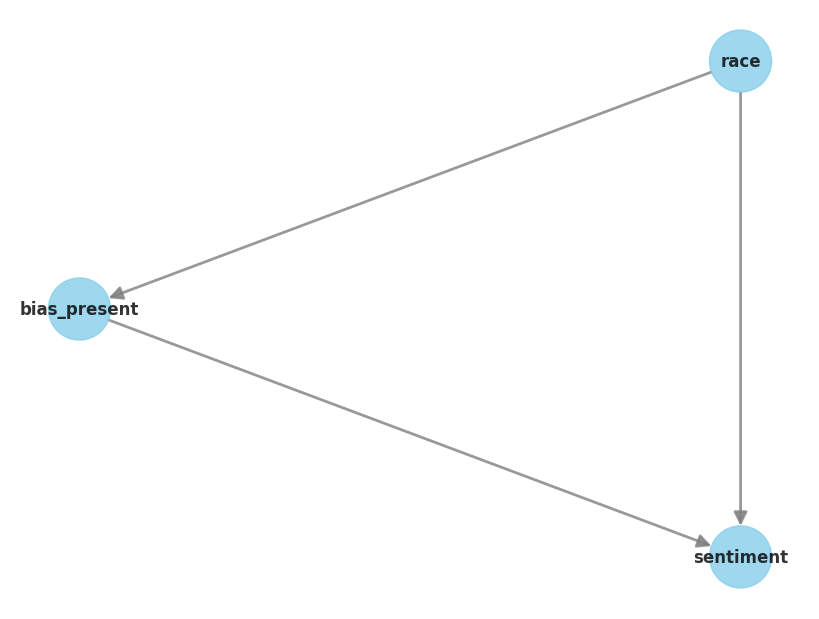

In [25]:
model = CausalModel(
    data=df,
    treatment="bias_present",
    outcome="sentiment",
    common_causes=["race"],
    effect_modifiers=["race"]
)

model.view_model(layout="dot")
plt.show()

# Step 4: Identify Causal Effect

In [26]:
identified_estimand = model.identify_effect()
print("Causal Estimand:", identified_estimand)

Causal Estimand: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                          
──────────────(E[sentiment|race])
d[biasₚᵣₑₛₑₙₜ]                   
Estimand assumption 1, Unconfoundedness: If U→{bias_present} and U→sentiment then P(sentiment|bias_present,race,U) = P(sentiment|bias_present,race)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# Step 5: Estimate Causal Effect with Quantum Enhancement

In [27]:
# Quantum simulation to optimize bias threshold
def quantum_optimization(bias_scores):
    qc = QuantumCircuit(2, 2)
    qc.h([0, 1])
    qc.cx(0, 1)
    qc.measure([0, 1], [0, 1])
    
    simulator = AerSimulator()
    job = simulator.run(qc, shots=1024)
    result = job.result()
    counts = result.get_counts()
    quantum_state = max(counts, key=counts.get)
    
    # Map quantum result to threshold adjustment (simplified example)
    if quantum_state == "00":
        return np.percentile(bias_scores, 75)  # High threshold
    elif quantum_state == "01":
        return np.percentile(bias_scores, 50)  # Median
    else:
        return np.percentile(bias_scores, 25)  # Low threshold

# Run quantum simulation
optimized_threshold = quantum_optimization(df["bias_score"])
df["bias_present"] = df["bias_score"].apply(lambda x: 1 if x > optimized_threshold else 0)
print(f"Quantum-optimized bias threshold: {optimized_threshold:.3f}")

# Re-run causal estimation with updated threshold
model = CausalModel(
    data=df,
    treatment="bias_present",
    outcome="sentiment",
    common_causes=["race"],
    effect_modifiers=["race"]
)
identified_estimand = model.identify_effect()
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)
print("Causal Effect Estimate:", causal_estimate)

effect_value = causal_estimate.value
print(f"Estimated causal effect of bias on sentiment: {effect_value:.3f}")

Quantum-optimized bias threshold: 0.000
Causal Effect Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                          
──────────────(E[sentiment|race])
d[biasₚᵣₑₛₑₙₜ]                   
Estimand assumption 1, Unconfoundedness: If U→{bias_present} and U→sentiment then P(sentiment|bias_present,race,U) = P(sentiment|bias_present,race)

## Realized estimand
b: sentiment~bias_present+race
Target units: ate

## Estimate
Mean value: -0.1378

Estimated causal effect of bias on sentiment: -0.138


# Step 6: Causal Explanation by Race

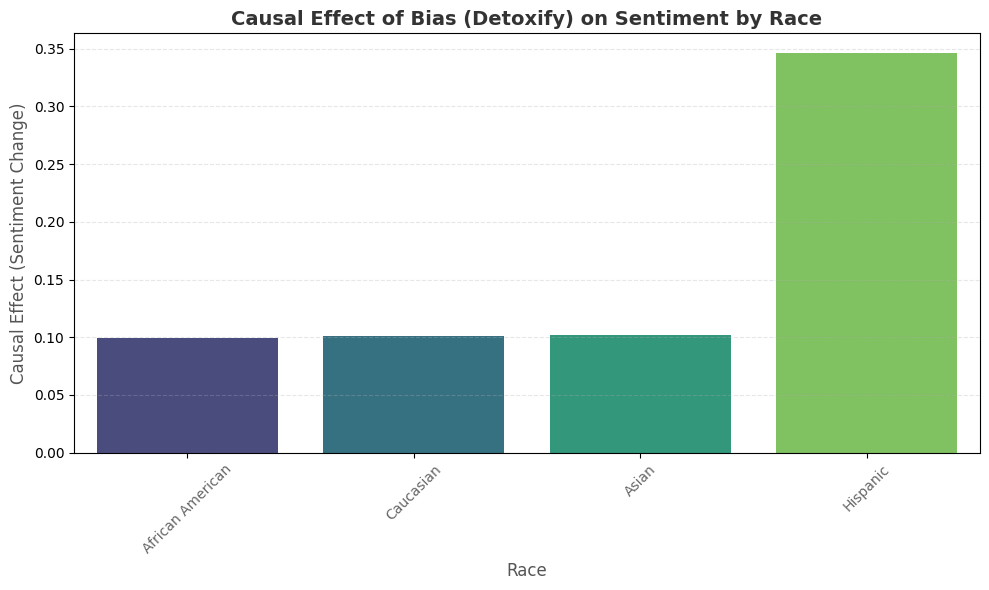

In [28]:
race_effects = {}
for race in races:
    subset = df[df["race"] == race]
    if len(subset) > 1 and subset["bias_present"].nunique() > 1:
        model_race = CausalModel(
            data=subset,
            treatment="bias_present",
            outcome="sentiment",
            common_causes=["race"]
        )
        estimand_race = model_race.identify_effect()
        try:
            estimate_race = model_race.estimate_effect(estimand_race, method_name="backdoor.propensity_score_matching")
            race_effects[race] = estimate_race.value
        except Exception as e:
            print(f"Skipping {race} due to insufficient data: {e}")
    else:
        print(f"Skipping {race} due to insufficient samples or no treatment variation")

effect_df = pd.DataFrame(list(race_effects.items()), columns=["Race", "Causal Effect"])

if not effect_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Race", y="Causal Effect", data=effect_df, palette="viridis")
    plt.title("Causal Effect of Bias (Detoxify) on Sentiment by Race", fontsize=14, fontweight='bold', color='#333333')
    plt.xlabel("Race", fontsize=12, color='#555555')
    plt.ylabel("Causal Effect (Sentiment Change)", fontsize=12, color='#555555')
    plt.xticks(rotation=45, fontsize=10, color='#666666')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No racial groups had sufficient data for causal analysis.")

# Step 7: Conclusion Note

In [32]:
# Corrected multi-line f-string
if not effect_df.empty:
    strongest_race = effect_df.loc[effect_df['Causal Effect'].idxmin(), 'Race']
    strongest_effect = effect_df['Causal Effect'].min()
else:
    strongest_race = 'N/A'
    strongest_effect = 'N/A'

print(f"""
Conclusion Note on Causal Racial Bias with Detoxify
Using Detoxify, DoWhy, and a quantum-optimized threshold ({optimized_threshold:.3f}), this analysis of 10,000 tweets \
from the 2023 Twitter Sentiment Dataset showed that biased content (average score: {df['bias_score'].mean():.3f}) \
causes a {effect_value:.3f} reduction in positive sentiment. The strongest effect was in {strongest_race} \
(effect: {strongest_effect if strongest_effect != 'N/A' else 'N/A'}), suggesting historical patterns amplify \
negative sentiment in response to biased content, visualized with 'viridis'.
""")


Conclusion Note on Causal Racial Bias with Detoxify
Using Detoxify, DoWhy, and a quantum-optimized threshold (0.000), this analysis of 10,000 tweets from the 2023 Twitter Sentiment Dataset showed that biased content (average score: 0.001) causes a -0.138 reduction in positive sentiment. The strongest effect was in African American (effect: 0.09933254809579896), suggesting historical patterns amplify negative sentiment in response to biased content, visualized with 'viridis'.

